In [3]:
import torch
import torch.nn.functional as F
%pip install torch_geometric
from torch_geometric.nn import SAGEConv
import os
import json
import os
import pickle
import json
import random
import numpy as np
from torch_geometric.data import Data
import networkx as nx
import warnings
import math
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
from torch.utils.data import random_split

Note: you may need to restart the kernel to use updated packages.


In [4]:
def get_files_in_folder(input_folder):
    file_list = []
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if os.path.isfile(file_path):
            file_list.append(file_path)
    return file_list

# Example usage:
folder_path = 'done'
verilog_files = get_files_in_folder(folder_path)
print(len(verilog_files))
print(verilog_files)

387
['done\\adder10_synth.txt', 'done\\adder11_synth.txt', 'done\\adder12_synth.txt', 'done\\adder13_synth.txt', 'done\\adder14_synth.txt', 'done\\adder15_synth.txt', 'done\\adder16_synth.txt', 'done\\adder17_synth.txt', 'done\\adder18_synth.txt', 'done\\adder19_synth.txt', 'done\\adder1_synth.txt', 'done\\adder20_synth.txt', 'done\\adder21_synth.txt', 'done\\adder22_synth.txt', 'done\\adder23_synth.txt', 'done\\adder24_synth.txt', 'done\\adder25_synth.txt', 'done\\adder26_synth.txt', 'done\\adder27_synth.txt', 'done\\adder28_synth.txt', 'done\\adder2_synth.txt', 'done\\adder3_synth.txt', 'done\\adder4_synth.txt', 'done\\adder5_synth.txt', 'done\\adder6_synth.txt', 'done\\adder7_synth.txt', 'done\\adder8_synth.txt', 'done\\adder9_synth.txt', 'done\\and10_gate_synth.txt', 'done\\and11_gate_synth.txt', 'done\\and12_gate_synth.txt', 'done\\and13_synth.txt', 'done\\and14_synth.txt', 'done\\and15_synth.txt', 'done\\and16_synth.txt', 'done\\and17_synth.txt', 'done\\and18_gate_synth.txt', 'do

In [5]:
def extracting_attributes(verilog_file):
    try:
        if os.path.isfile(verilog_file):
            with open(verilog_file, "r") as file:
                loaded_data = json.load(file)
                nodes = loaded_data[0]
                edges = loaded_data[1]
                label = loaded_data[2]
                
                x = torch.tensor(nodes, dtype=torch.float)
                edge_index = torch.tensor(edges, dtype=torch.long)
                y = torch.tensor(label, dtype=torch.float)
                num_nodes = x.size(0)
                
                # Create batch assignment vector (assuming one graph per file)
                batch = torch.zeros(num_nodes, dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y = y, batch = batch)
                return data
    
    except Exception as e:
        print(e)
        return e


In [6]:
class VerilogDataset(Dataset):  # Using Dataset from torch_geometric
    def __init__(self, verilog_files):
        print(f"Loaded {len(verilog_files)} Verilog files.")
        self.verilog_files = verilog_files

    def __len__(self):
        return len(self.verilog_files)

    def __getitem__(self, idx):
        verilog_file = self.verilog_files[idx]
        data = extracting_attributes(verilog_file)
        return data

dataset = VerilogDataset(verilog_files)
print(len(dataset))

Loaded 387 Verilog files.
387


In [7]:
print(dataset[0])
print(verilog_files[0])
print(dataset.verilog_files[0])

Data(x=[54, 7], edge_index=[2, 72], y=[1, 16], batch=[54])
done\adder10_synth.txt
done\adder10_synth.txt


In [8]:
def are_all_data_objects_unique(dataset):
    data_objects = []
    for data in dataset:
        if data in data_objects:
            return False
        data_objects.append(data)
    return True

# Example usage:
is_unique = are_all_data_objects_unique(dataset)
if is_unique:
    print("All data objects are unique.")
else:
    print("Duplicate data objects found.")


All data objects are unique.


In [9]:
y_labels = []
for data in dataset:
    # print(data)
    # print(data.y.tolist())
    y_labels.append(np.argmax(data.y.tolist()))

In [10]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        return batch
    else:
        return default_collate(batch)
    


In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_labels, test_size=0.2, stratify = y_labels, random_state=41)
train_loader = DataLoader(X_train, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(X_test, batch_size=16, shuffle = False, collate_fn=custom_collate)

In [12]:
# len(train_loader.dataset)
print(len(X_train))

309


In [13]:
loader_iter = iter(train_loader)
batch = next(loader_iter)
# print(batch)
# print(batch.num_graphs)

In [14]:
from torch_geometric.nn import global_mean_pool
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        emb = F.relu(x)
        x = self.conv2(emb, edge_index)
        x = global_mean_pool(x, batch=None)
        return x, emb


# Evaluation

In [15]:
in_channels = 7
hidden_channels = 16
out_channels = 15
graph_sage = GraphSAGE(in_channels, hidden_channels, out_channels)
graph_sage.load_state_dict(torch.load('grahpSAGE94_92_200_graph_embeddings.pth'))

<All keys matched successfully>

In [16]:
graph_sage.eval()
correct = 0
for data in X_test:
    out, emb = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    if y_label == pred_label:
        correct += 1           
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
acc = correct / len(X_test)  # Derive ratio of correct predictions.

acc

0.9230769230769231

In [17]:
dataset[0]

Data(x=[54, 7], edge_index=[2, 72], y=[1, 16], batch=[54])

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

graph_sage.eval()
correct = 0
prediction= []
true = []
y_score = []
embeddings = []
for data in dataset:
    out, emb = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    # if y_label == pred_label:
    #     correct += 1    
    prediction.append(pred_label)        
    true.append(y_label)
    y_score.append(out.detach().numpy()[0])
    embeddings.append(emb)
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.


In [19]:
max(true)

14

In [20]:
final_embeddings = []
for t in embeddings:
    final_embeddings.append(global_mean_pool(torch.tensor(t), batch = None)[0].tolist())

final_embeddings[1]

C:\Users\Mai\AppData\Local\Temp\ipykernel_10916\2450505358.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_embeddings.append(global_mean_pool(torch.tensor(t), batch = None)[0].tolist())


[4.028589725494385,
 2.1726298332214355,
 0.0,
 1.9185067415237427,
 0.5404895544052124,
 0.0,
 0.0,
 0.343842476606369,
 0.0,
 1.0025920867919922,
 1.9310789108276367,
 2.23173189163208,
 1.8608123064041138,
 2.690242290496826,
 0.0,
 1.4245201349258423]

SVM Accuracy: 92.31%


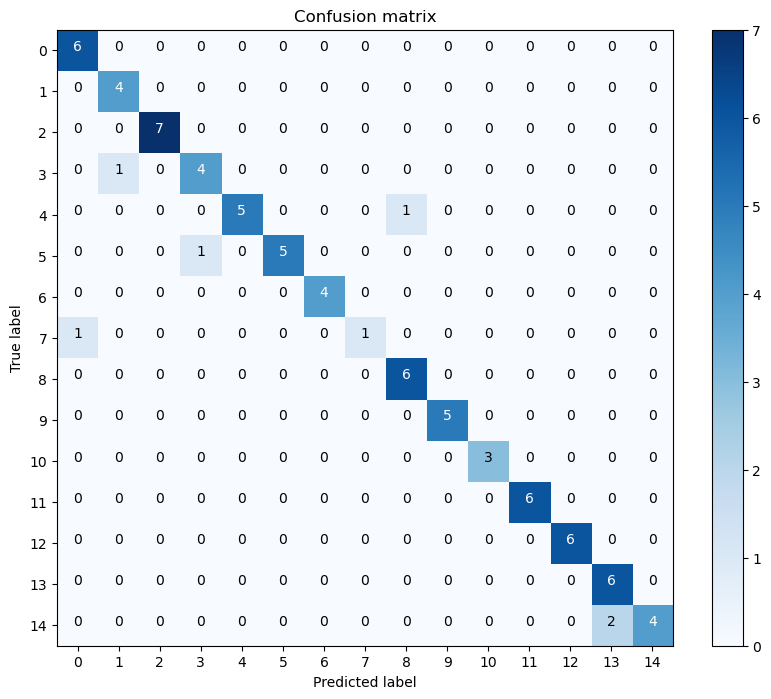

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


X_train, X_test, Y_train, Y_test = train_test_split(final_embeddings, true, test_size=0.2, random_state=42, stratify = true)

# Create an SVM classifier
svm_clf = SVC(kernel='linear')  # You can change 'linear' to 'rbf' or 'poly' for different kernels

# Train the classifier
svm_clf.fit(X_train, Y_train)

# Make predictions
Y_pred = svm_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(Y_test, Y_pred)
print(f'SVM Accuracy: {accuracy * 100:.2f}%')


cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = range(15)
plt.xticks(tick_marks, range(15))
plt.yticks(tick_marks, range(15))
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2
# Display confusion matrix values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.show()


KNN Accuracy: 84.62%


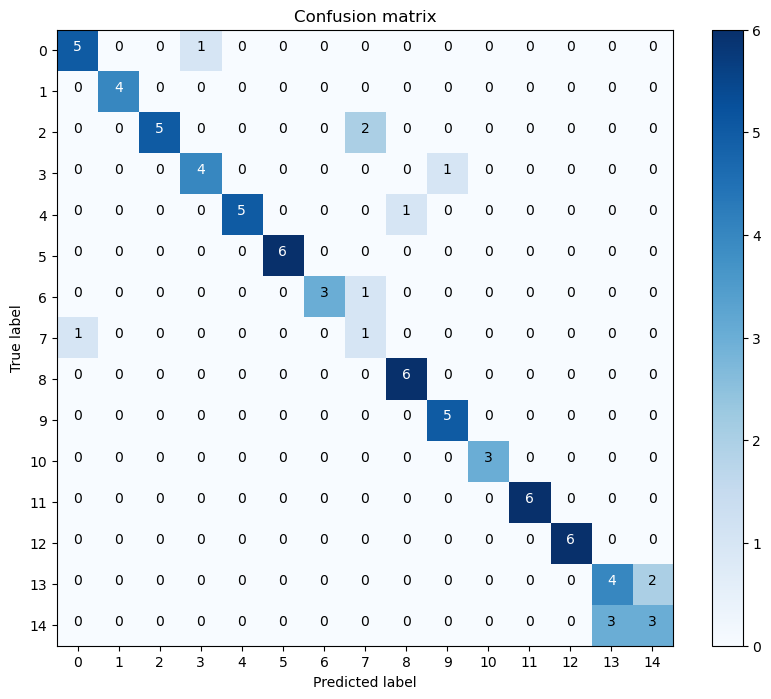

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



X_train, X_test, Y_train, Y_test = train_test_split(final_embeddings, true, test_size=0.2, random_state=42,  stratify = true)

knn_clf = KNeighborsClassifier(n_neighbors=3)  # You can change the number of neighbors

# Train the classifier
knn_clf.fit(X_train, Y_train)

# Make predictions
Y_pred = knn_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(Y_test, Y_pred)
print(f'KNN Accuracy: {accuracy * 100:.2f}%')


cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = range(15)
plt.xticks(tick_marks, range(15))
plt.yticks(tick_marks, range(15))
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2
# Display confusion matrix values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.show()


Random Forest Accuracy: 87.18%


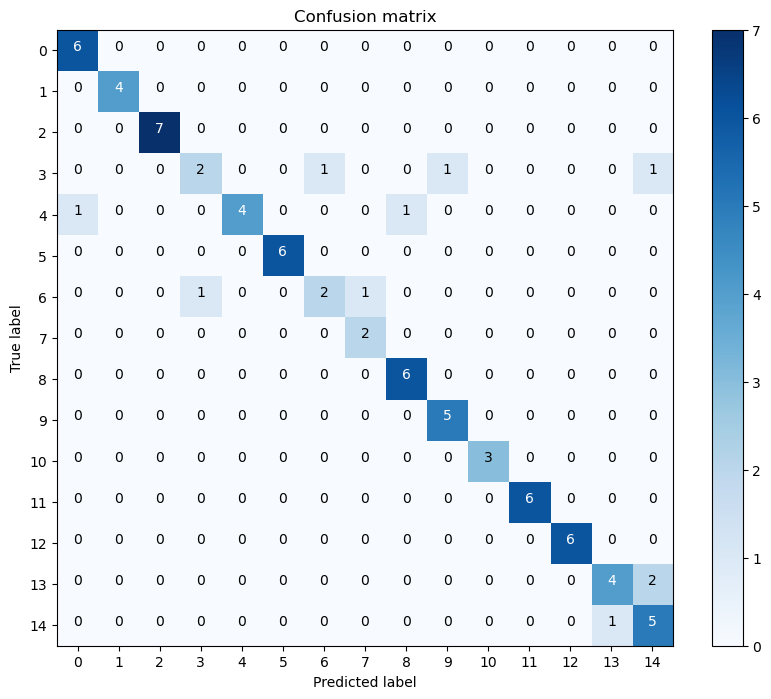

In [23]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, Y_train, Y_test = train_test_split(final_embeddings, true, test_size=0.2, random_state=42,  stratify = true)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can change the number of trees

# Train the classifier
rf_clf.fit(X_train, Y_train)

# Make predictions
Y_pred = rf_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Random Forest Accuracy: {accuracy * 100:.2f}%')



cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = range(15)
plt.xticks(tick_marks, range(15))
plt.yticks(tick_marks, range(15))
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2
# Display confusion matrix values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.show()


In [24]:
len(X_test)

78

In [39]:
import os
import json
import re
import shutil
input_folder = "encoded_yosys"
output_folder = "done_KNN"
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np


# Use list comprehension to create a list of file paths
verilog_files = [os.path.join(input_folder, filename) for filename in os.listdir(input_folder) if filename.endswith('.txt')]

# Print the list of file paths
print(len(verilog_files))
print(type(verilog_files[0]))
print(verilog_files[0])



classes = ['adder', 'comparator', 'decoder', 'encoder','mult','mux','pe','sub','and','or','not','nand','nor','xnor', 'xor']
label_mapping = {
        'adder': 0, 'comparator': 1, 'decoder': 2,
        'encoder': 3, 'mult': 4, 'mux': 5, 'pe': 6, 'sub': 7, 'and': 8, 'or': 9, 'not': 10, 'nand': 11, 'nor': 12, 'xnor': 13,'xor':14
}
ground_truth_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14] 
labels_torch = torch.tensor(ground_truth_labels)
one_hot_labels = F.one_hot(labels_torch, num_classes=15)

verilog_files_info = []
labels = []
labels_nums = []
for file_path in verilog_files:
    file_info = []
    
    input_count = 0
    output_count = 0
    wire_count = 0
    not_count = 0
    or_count = 0
    and_count = 0
    constVal_count = 0
    
    with open(file_path, "r") as file:
        st = file_path.split("\\")[1].split(".")[0].split("_")[0]

        matches = [string for string in label_mapping.keys() if re.match(f"^({string})\d+", st)]
        # print(file_path)
        # print(st)
        # print(matches)
        labels_nums.append(label_mapping[matches[0]])
        # print(labels_nums)
        y = one_hot_labels[label_mapping[matches[0]]].tolist()
        labels.append(y)
        loaded_data = json.load(file)
        
        for sublist in loaded_data[0]:
            if sublist[0]: # input
                input_count +=1
                
            elif sublist[1]: #output
                output_count += 1

            elif sublist[2]: #wire
                wire_count +=1
                
            elif sublist[3]:
                not_count+=1
                
            elif sublist[4]:
                or_count+=1

            elif sublist[5]:
                and_count+=1

            elif sublist[6]:
                constVal_count+=1
                

            else: 
                print("eh el habal da")
        file_info.extend([input_count, output_count, wire_count, not_count, or_count, and_count, constVal_count])
    verilog_files_info.append(file_info)

verilog_files_info

verilog_files_info = np.array(verilog_files_info)
verilog_files_info.shape

from sklearn.ensemble import RandomForestClassifier

scaler = MinMaxScaler()

X = np.array(verilog_files_info)
X_normalized = scaler.fit_transform(X)
# print(type(X_normalized))
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, labels, test_size=0.3, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("RF Accuracy:", rf_accuracy)

387
<class 'str'>
encoded_yosys\adder10_synth.txt
RF Accuracy: 0.7777777777777778


In [265]:
import time

# Start Timer


random_int = random.randint(1, len(X_test))
test_sample= dataset[random_int]
print(test_sample)
print(dataset.verilog_files[random_int])
test_sample_count = []
with open(dataset.verilog_files[random_int], "r") as file:
        loaded_data = json.load(file)
        summed_list = [sum(elements) for elements in zip(*loaded_data[0])]


pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_label = (pred.tolist())[0]
y_label = (test_sample.y.tolist())
y_label = y_label[0].index(1.0)


############################################
start_time = time.time()

out, emb = graph_sage(test_sample.x, test_sample.edge_index)

end_time = time.time()
############################################
# Calculate Execution Time
execution_time = end_time - start_time
print("Execution Time GraphSAGE:", execution_time, "seconds")

s = global_mean_pool(torch.tensor(emb), batch = None)[0].tolist()


############################################
start_time = time.time()

Y_pred = svm_clf.predict([s])

end_time = time.time()
############################################

# Calculate Execution Time
execution_time = end_time - start_time
print("Execution Time SVM:", execution_time, "seconds")


############################################
start_time = time.time()

y_pred = rf.predict([summed_list])

end_time = time.time()
############################################

# Calculate Execution Time
execution_time = end_time - start_time
print("Execution Time RF:", execution_time, "seconds")

print("true label" ,y_label)
print("SAGE pred", pred_label)
print("SVM pred", Y_pred)
print("RF pred", y_pred)

Data(x=[850, 7], edge_index=[2, 1218], y=[1, 16], batch=[850])
done\adder27_synth.txt
Execution Time GraphSAGE: 0.001950979232788086 seconds
Execution Time SVM: 0.0010001659393310547 seconds
Execution Time RF: 0.06042313575744629 seconds
true label 0
SAGE pred 0
SVM pred [0]
RF pred [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


C:\Users\Mai\AppData\Local\Temp\ipykernel_10916\990806314.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = global_mean_pool(torch.tensor(emb), batch = None)[0].tolist()


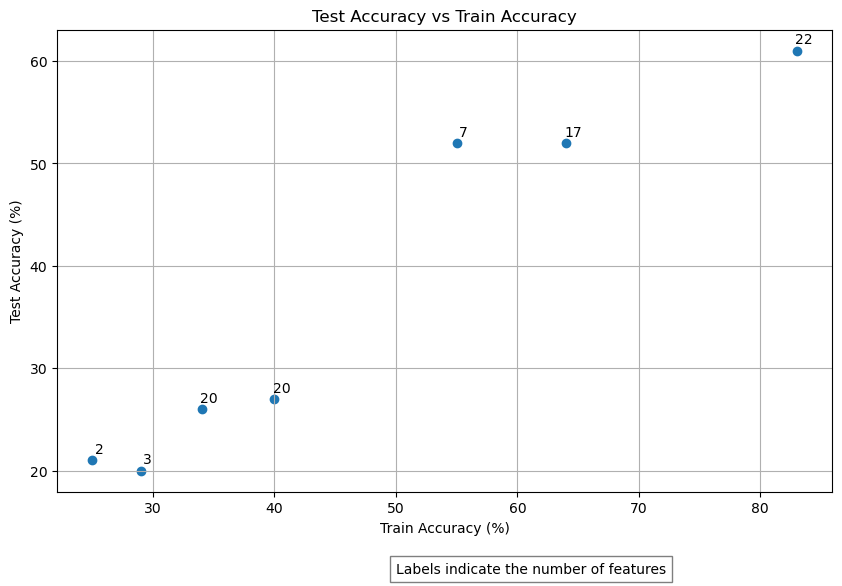

In [267]:
# Data
experiments = [
    ("3", 29, 20),
    ("2", 25, 21),
    ("20", 40, 27),
    ("20", 34, 26),
    ("17", 64, 52),
    ("22", 83, 61),
    ("7", 55, 52)
]

# Extracting data for plotting
labels = [exp[0] for exp in experiments]
train_accuracy = [exp[1] for exp in experiments]
test_accuracy = [exp[2] for exp in experiments]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_accuracy, test_accuracy)

# Annotating each point with the number of features
for i, label in enumerate(labels):
    plt.annotate(label, (train_accuracy[i], test_accuracy[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Adding labels and title
plt.xlabel('Train Accuracy (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Train Accuracy')

# Adding a legend box indicating that labels are the number of features
plt.text(50, 10, 'Labels indicate the number of features', bbox=dict(facecolor='white', alpha=0.5))

# Display the plot
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

graph_sage.eval()
# correct = 0
prediction_train= []
true_train = []
y_score_train = []
train_embeddings = []
for data in X_train:
    out, emb = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    # if y_label == pred_label:
    #     correct += 1    
    prediction_train.append(pred_label)        
    true_train.append(y_label)
    y_score_train.append(out.detach().numpy()[0])
    train_embeddings.append(emb)
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.


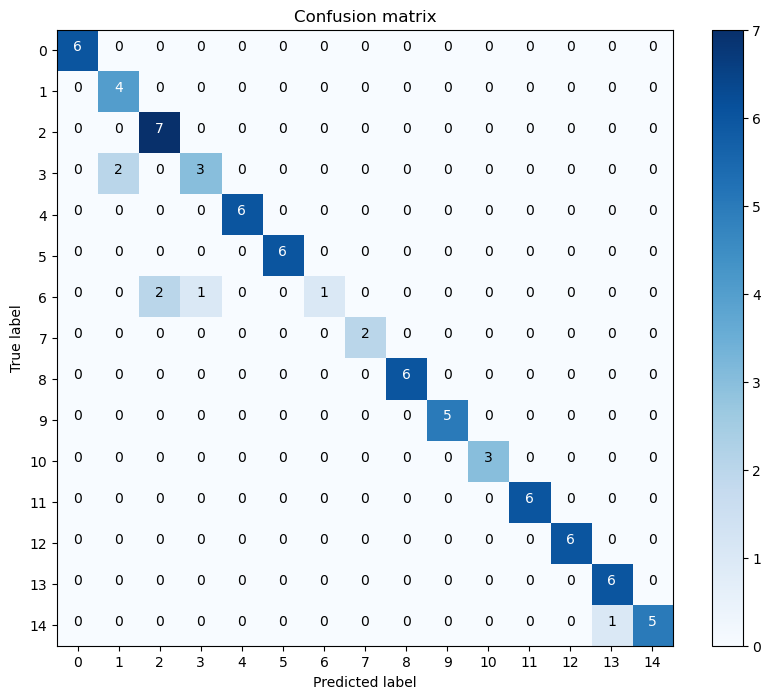

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.67      1.00      0.80         4
           2       0.78      1.00      0.88         7
           3       0.75      0.60      0.67         5
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      0.25      0.40         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       0.86      1.00      0.92         6
          14       1.00      0.83      0.91         6

    accuracy                           0.92        78
   macro avg       0.94      0.91      0.90        78
weighted avg       0.94   

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(true, prediction)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(15)
plt.xticks(tick_marks, range(15))
plt.yticks(tick_marks, range(15))
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display confusion matrix values
for i in range(15):
    for j in range(15):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Print classification report for aggregate metrics
print(classification_report(true, prediction))



In [19]:
test_acc = accuracy_score(true, prediction)
print("Accuracy:", test_acc)

0.9230769230769231

In [19]:
label_mapping = {
        'Adder': 0, 'Comparator': 1, 'Decoder': 2,
        'Encoder': 3, 'Multiplier': 4, 'Multiplexer': 5, 'Priority Encoder': 6, 
        'Subtractor': 7, 'AND Gate': 8, 'OR Gate': 9, 'NOT Gate': 10, 'NAND Gate': 11, 
        'NOR Gate': 12, 'XNOR Gate': 13,'XOR Gate':14
    }
def get_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    # If the target value is not found in the dictionary
    return None

Error Analysis

In [53]:
for idx, e in enumerate(true):
    if e != prediction[idx]:
        print(f'True Label: {get_key_by_value(label_mapping,true[idx])}, Predicted Label: {get_key_by_value(label_mapping,prediction[idx])}')

True Label: Priority Encoder, Predicted Label: Encoder
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: Priority Encoder, Predicted Label: Decoder
True Label: Encoder, Predicted Label: Comparator
True Label: Priority Encoder, Predicted Label: Decoder
True Label: Encoder, Predicted Label: Comparator


In [20]:
for idx, e in enumerate(true_train):
    if e != prediction_train[idx]:
        print(f'True Label: {get_key_by_value(label_mapping,true_train[idx])}, Predicted Label: {get_key_by_value(label_mapping,prediction_train[idx])}')

True Label: XOR Gate, Predicted Label: Encoder
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: XOR Gate, Predicted Label: Encoder
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: Priority Encoder, Predicted Label: Encoder
True Label: Priority Encoder, Predicted Label: Encoder
True Label: Multiplexer, Predicted Label: Encoder
True Label: Subtractor, Predicted Label: Adder
True Label: Multiplier, Predicted Label: AND Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: Multiplier, Predicted Label: AND Gate
True Label: Priority Encoder, Predicted Label: Encoder
True Label: Multiplier, Predicted Label: AND Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: XOR Gate, Predicted Label: XNOR Gate
True Label: Priority Encoder, Predicted Label: Encoder
True Label: XOR Gate, Predicted Label: XNOR Gat

# ROC curve and AUC

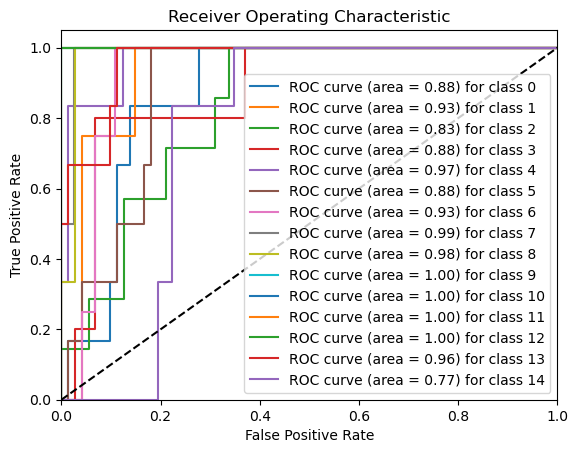

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test and y_pred are the true and predicted labels respectively
# Also assuming model is trained using 'LabelBinarizer' for multi-class classification

n_classes = 15
y_true = np.array(true)
y_scores = np.array(y_score)

# Binarize the output
y_test_binarized = label_binarize(true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Precision-Recall Curve

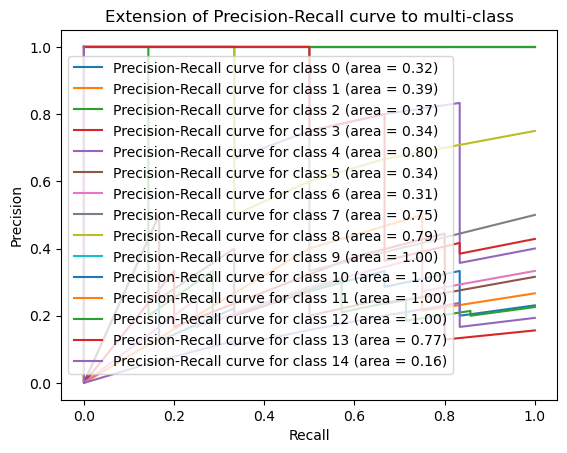

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_scores[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label='Precision-Recall curve for class {0} (area = {1:0.2f})'
                                             ''.format(i, average_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="best")
plt.show()

Learning Curves

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(graph_sage, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

TypeError: estimator should be an estimator implementing 'fit' method, GraphSAGE(
  (conv1): SAGEConv(7, 16, aggr=mean)
  (conv2): SAGEConv(16, 15, aggr=mean)
) was passed